In [1]:
# Luminosity, Schechter function, etc. 

# Runtime error:

# Need to calculate E(z) only once, and re-use that vector for each calculation of Distance Modulus, rather than
# having the integrals nested.

# should also check for divide by zero, or numbers going above max double float size (-1.797e+308, 1.797e+308)
# 

# Imports
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt


In [105]:
# David Hogg Paper
EDS = np.array([1, 0, 0])
LD = np.array([0.05, 0, 0.95])
HL = np.array([0.2, 0.8, 0])

#Msci paper
# Omega M, Omega Lambda, Omega K
LCDM = np.array([0.3, 0.7, 0])
EDS = np.array([1, 0, 0])
OCDM = ([0.3, 0, 0.7])

# W0, W1
wBasic = np.array([-1, 0])
w8 = np.array([-0.8, 0])
w9 = np.array([-0.9, 0])
w11 = np.array([-1.1, 0])
w12 = np.array([-1.2, 0])

# Schecher parameters
# Phi1, Phi2, a1, a2, Mass*
# The Schechter parameters found  in the paper by Baldry, Driver, Loveday, Taylor et al. (2011)
CanonicalSchechter = np.array([3.96*10**-3, 0.79*10**-3, -0.35, -1.47, 10**10.66])

zArray = np.linspace(0.01, 5, num = 200)
MagArray = np.linspace(-30, 50, num = 200)

In [106]:
# Constants

#c = 3 * 10**8 #m.s-1
H_0 = 70 #Mpc
#D_H = (c / H_0)
MSol = 1.99 * 10**30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 1: Setting up distances and Distance Modulus

In [107]:
def Ez(z, OmeM, OmeCos, OmeK, w0, w1): #Doesn't switch equation automatically
    if OmeK > 0: # Is this distribution of equations true?
        return np.sqrt(OmeM * (1 + z)**3 + OmeK * (1 + z)**2 + OmeCos)
    elif OmeK == 0:
        return np.sqrt(OmeM * (1 + z)**3 + (1 - OmeM) * (1 + z)**(3 * (1 + w0 + w1)) * np.exp(-3 * w1 * z))

In [108]:
# Comoving distance for line-of-sight distance calculation

def ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1):
    integral = integrate.quad(lambda Z: 1/(Ez(Z, OmeM, OmeCos, OmeK, w0, w1)), 0, z) # integration holds error
    return integral[0]

ComDisLOSVec = np.vectorize(ComDisLOS, excluded=['ws'])

In [109]:
def ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1):
    if OmeCos == 0:
        A = 2 - OmeM * (1-z)
        B = (2 - OmeM) * np.sqrt(1 + OmeM * z)
        C = OmeM**2 * (1 + z)
        distance = 2 * (A - B)/C
        return distance
        
    else:
        if OmeK > 0:
            distance = (1 / np.sqrt(OmeK)) * np.sinh(np.sqrt(OmeK) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK < 0:
            distance = (1 / np.sqrt(np.absolute(OmeK))) * np.sin(np.sqrt(np.absolute(OmeK)) * ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1) )
        elif OmeK == 0:
            distance = ComDisLOS(z, OmeM, OmeCos, OmeK, w0, w1)
    return distance

ComDisTraVec = np.vectorize(ComDisTra, excluded=['ws'])

In [110]:
# Luminosity distance

def LumDist(z, OmeM, OmeCos, OmeK, w0, w1):
    return (1 + z) * ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1)

In [141]:
# Distance Modulus

def DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1):
    return 5 * np.log10(LumDist(z, OmeM, OmeCos, OmeK, w0, w1)*3*10**8 *0.7) #(D_H * 10**(-10)))
                        
DistModVec = np.vectorize(DistanceModulus)

In [142]:
# Zs = np.linspace(0.01,5, num=200)
# DMs = DistModVec(Zs, 1, 0, 0, -1, 0)

# plt.plot(Zs, DMs)
# plt.show()

In [143]:
# Angular diameter distance

def DiamDist(z, OmeM, OmeCos, OmeK, w0, w1):
    return (ComDisTra(z, OmeM, OmeCos, OmeK, w0, w1) / (1 + z))

DiamDistVec = np.vectorize(DiamDist, excluded=['ws'])


In [144]:
def ComVolEl(z, OmeM, OmeCos, OmeK, w0, w1):
    return (1 + z)**2 * DiamDist(z, OmeM, OmeCos, OmeK, w0, w1)**2 / Ez(z, OmeM, OmeCos, OmeK, w0, w1) # delta solid angle?

ComVolElVec = np.vectorize(ComVolEl, excluded=['ws'])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 2: Double Schechter function; playing around and trying to get it to work

In [145]:
# magnitudes = np.linspace(5, 15, num = 200)

# def SchechterDiff(Phi, a, Mstar, M):
#     return Phi * np.log(10) * (10**(0.4*(Mstar - M)))**(a + 1) * np.exp(-10**(0.4*(Mstar-M)))

# #np.vectorize(SchechterDiff)

# def Schechter(Phi, a, Mstar, M):
#     integral = integrate.quad(lambda m: (SchechterDiff(Phi, a, Mstar, m)), 0, np.inf) # integration holds error
#     return integral[0]

# values = SchechterDiff(1.2 * 10**(-2), -0.25, 7, magnitudes)

# plt.plot(magnitudes, values)
# plt.show()

# SchechterVec = np.vectorize(Schechter)

In [146]:
# Schechter function for masses
# Double schechter function from paper by Baldry, Driver, Loveday, Taylor et al. (2011)

def DoubleSchechterDiff(Phi1, Phi2, a1, a2, MassStar, Mass): #in MASSES =( (Solar masses)
    Density = np.exp(-Mass/(MassStar)) * (Phi1 * (Mass/(MassStar))**a1 + Phi2 * (Mass/(MassStar))**a2 ) * (1/(MassStar))
    #Density = np.exp(-Mass/(MassStar)) * (Phi1 * (Mass/(MassStar))**a1 + Phi2 * (Mass/(MassStar))**a2 ) * (Mass/(MassStar))
    # For units as in the paper, we have d(mass)/ d(log(mass)) = mass
    return Density


DoubleSchechterDiffVec = np.vectorize(DoubleSchechterDiff)

Checking that the function behaves as in the Baldry, Driver, Loveday, Taylor et al. (2011) paper for masses.

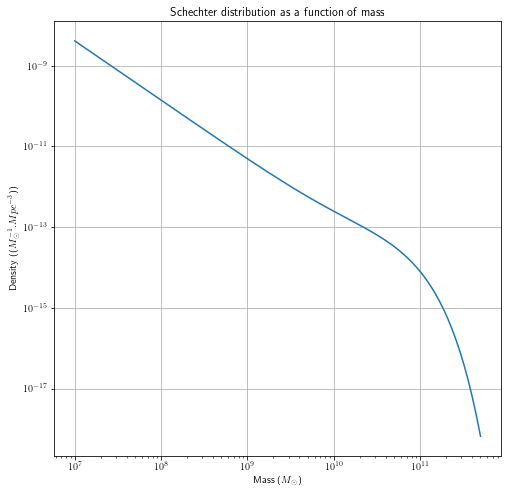

In [147]:
masses = np.logspace((7 - 2 * np.log(H_0/70)), (11.7 - 2 * np.log(H_0/70)), num = 200)
densities = DoubleSchechterDiffVec(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], \
                                 CanonicalSchechter[3], CanonicalSchechter[4], masses)


    
   
plt.figure(figsize=(8,8))

plt.title("Schechter distribution as a function of mass")
plt.xlabel("Mass ($M_{\odot}$)")
plt.ylabel("Density (($M_{\odot}^{-1}. Mpc^{-3}$))")
plt.grid()
#plt.legend()

plt.plot(masses, densities)
plt.yscale("Log")
plt.xscale("Log")
plt.show()

# Behaviour as in Baldry, Driver, Loveday, Taylor et al. (2011)
# But y axis is wrong. Density varies too quickly

In [148]:
# Luminosity from mass
# But this is what Dr. Conselice said to do in the supervision meeting; "just use luminosity *3 or something"

# Mass to light ratio depends on age of galaxy, type of galaxy, whether in a cluster etc.

def LumfromMass(mass, MLratio):
    Lum = mass / (MLratio) # units of solar mass
    return Lum
# Mass from luminosity
def MassFromLum(Lum, MLratio):
    mass = Lum * MLratio
    return mass

In [149]:
# Absolute Magnitue from Luminosity
def MagnitudeFromLum(Lum):
    Mag = 4.74 - 2.5 * np.log10(Lum)
    #Mag = -2.5*np.log10(Lum * 1.27 * 10**(-2))
    return Mag

# Luminosity from absolute magnitude
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def LumFromMagnitude(Mag):
    #Lum = 10**(-Mag/2.5) / 1.27 * 10**(-2)
    Lum = 10**((4.74 - Mag)/2.5)
    return Lum

In [150]:
# magnitude from Absolute Magnitude
# m = M + DM + K
def MagFromAbsMag(Mag, DM, K):
    mag = Mag + DM + K
    return mag

def AbsMagFromMag(mag, DM, K):
    Mag = mag - DM - K
    return Mag


In [151]:
def DeltaAdjustment(mag, MLratio): # This function lets us account for changing the variable with respect to which
    # we are integrating, ie it is essentialy d(mass)/d(magnitude)
    return MLratio * np.log(10) * (1/2.5) * 10**((-mag)/2.5) * 10**(4.74/2.5)

In [152]:
# Schechter function as a distribution of magnitudes 
# 
def SchechterMagnitudes(Phi1, Phi2, a1, a2, MassStar, Mag, MLratio): # Schechter as a function of magnitudes
    #Density = DeltaAdjustment(mag, DM, MLratio) * DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(AbsMagFromMag(mag, DM, K)), MLratio))
    Density = DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(Mag), MLratio))
    return Density

def SchechterMagnitudesdMag(Phi1, Phi2, a1, a2, MassStar, Mag, MLratio):#dMag for delta magnitude, so we can integrate
    Density = DeltaAdjustment(Mag, MLratio) * DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(Mag), MLratio))
    #Density = DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude(Mag), MLratio))
    return Density

SchechterMagnitudesVec = np.vectorize(SchechterMagnitudes)
SchechterMagnitudesdMagVec = np.vectorize(SchechterMagnitudesdMag)

 We check that we can retrieve the same behaviour as in the mass function, but this time with an array of magnitudes.

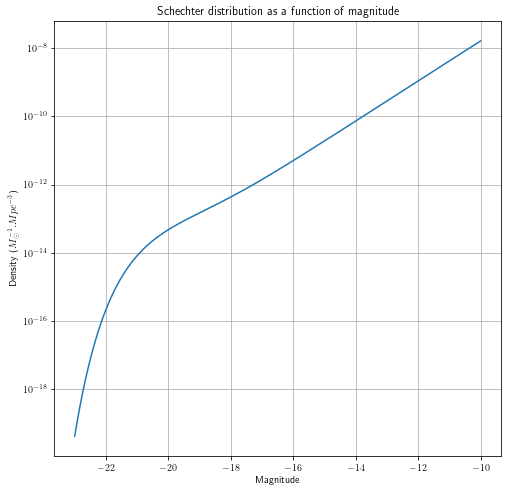

In [153]:
MagArray = np.linspace(-10, -23, num = 200)

MagnitudesDistrib = SchechterMagnitudes(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], MagArray, 5)

plt.figure(figsize=(8,8))

plt.title("Schechter distribution as a function of magnitude")
plt.xlabel("Magnitude ")
plt.ylabel("Density ($M_{\odot}^{-1}. Mpc^{-3}$)")
plt.grid()
#plt.legend()

plt.plot(MagArray, MagnitudesDistrib)
plt.yscale("Log")
plt.show()


In [154]:
# Zs = np.linspace(0.01, 5, num = 200)

# DMs = DistModVec(Zs, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])

# #print(DMs)
# # How far is aboslute magnitude supposed to be? seems like DM always makes things brighter,
# # no matter how far away they are
# #m = M + DM + K

# test = integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - DMs[0]))
# print(test)

# test = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMs])
# #print(test)
# #Far too big!!! Numbers are huge.

# plt.plot(Zs, test)
# plt.yscale("Log")
# plt.show()

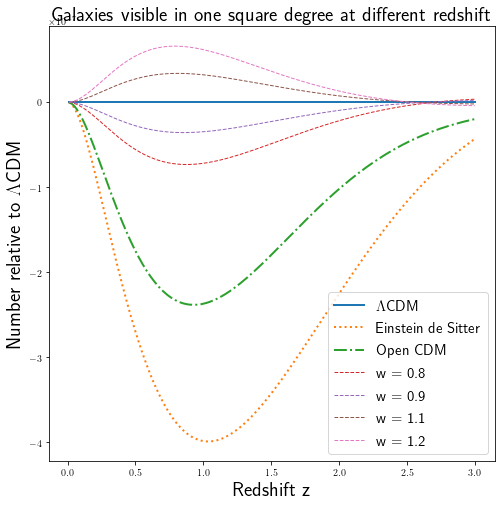

In [155]:
Zs = np.linspace(0.01, 3, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname, linestyle = "solid" , linewidth = 1):
    DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    Lambda = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsL])
    Cosmo = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsCos])
    
    Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
    Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
    Diff = np.subtract(Cosmo, Lambda)
    
    plt.plot(z, (Diff * (3.0462 * 10**(-4))), label = Cosmoname, linestyle = linestyle, linewidth = linewidth)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title, fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    #plt.grid()
    plt.legend(fontsize = 15)
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotVisibleDensity(LCDM, wBasic, Zs, "$\Lambda$CDM", linewidth = 2)
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter", linewidth = 2, linestyle =":")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open CDM", linewidth = 2, linestyle ="-.")

PlotVisibleDensity(LCDM, w8, Zs, "w = 0.8", linestyle = "--")
PlotVisibleDensity(LCDM, w9, Zs, "w = 0.9", linestyle = "--")
PlotVisibleDensity(LCDM, w11, Zs, "w = 1.1", linestyle = "--")
PlotVisibleDensity(LCDM, w12, Zs, "w = 1.2", linestyle = "--")


Roundoff("Galaxies visible in one square degree at different redshift", "Redshift z", "Number relative to $\Lambda$CDM")

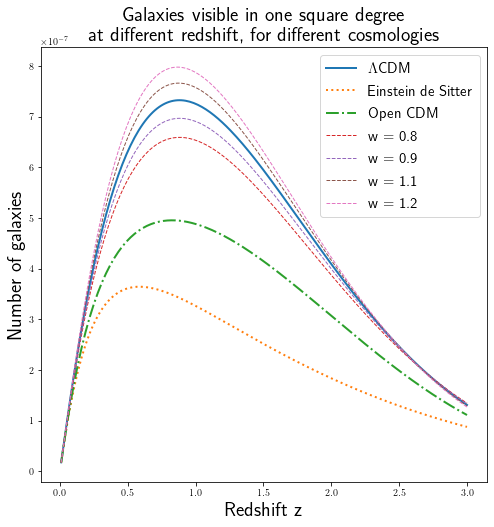

In [156]:
Zs = np.linspace(0.01, 3, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname, linestyle = "solid" , linewidth = 1):
    DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    Lambda = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsL])
    Cosmo = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsCos])
    
    Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
    Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
    #Diff = np.subtract(Cosmo, Lambda)
    
    plt.plot(z, (Cosmo * (3.0462 * 10**(-4))), label = Cosmoname, linestyle = linestyle, linewidth = linewidth)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title, fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    #plt.grid()
    plt.legend(fontsize = 15)
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotVisibleDensity(LCDM, wBasic, Zs, "$\Lambda$CDM", linewidth = 2)
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter", linewidth = 2, linestyle =":")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open CDM", linewidth = 2, linestyle ="-.")

PlotVisibleDensity(LCDM, w8, Zs, "w = 0.8", linestyle = "--")
PlotVisibleDensity(LCDM, w9, Zs, "w = 0.9", linestyle = "--")
PlotVisibleDensity(LCDM, w11, Zs, "w = 1.1", linestyle = "--")
PlotVisibleDensity(LCDM, w12, Zs, "w = 1.2", linestyle = "--")


Roundoff("Galaxies visible in one square degree \n at different redshift, for different cosmologies", "Redshift z", "Number of galaxies")

In [157]:
# Zs = np.linspace(0.01, 5, num = 200)

# def PlotDensityRelZ(Cosmology, Ws, z, Cosmoname, time, linestyle = "solid" , linewidth = 1):
#     DMsz = DistModVec(time, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
#     DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
#     atZ = integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - DMsz))[0]
#     Cosmo = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsCos])
    
#     atZ = np.prod([atZ, ComVolElVec(time, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
#     Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
#     RelDiff = np.subtract(Cosmo, atZ)
    
#     plt.plot(z, (RelDiff), label = Cosmoname, linestyle = linestyle, linewidth = linewidth)
#     #plt.yscale("Log")
    
# def Roundoff(title, xlabel, ylabel):
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     #plt.grid()
#     plt.legend()
    
#     plt.show()
    
   
# plt.figure(figsize=(8,8))

# PlotDensityRelZ(LCDM, wBasic, Zs, "$\Lambda$CDM", 3, linewidth = 2)
# PlotDensityRelZ(EDS, wBasic, Zs, "Einstein de Sitter", 3, linewidth = 2, linestyle =":")
# PlotDensityRelZ(OCDM, wBasic, Zs, "Open CDM", 3, linewidth = 2, linestyle ="-.")

# PlotDensityRelZ(LCDM, w8, Zs, "w = 0.8", 3, linestyle = "--")
# PlotDensityRelZ(LCDM, w9, Zs, "w = 0.9", 3, linestyle = "--")
# PlotDensityRelZ(LCDM, w11, Zs, "w = 1.1", 3, linestyle = "--")
# PlotDensityRelZ(LCDM, w12, Zs, "w = 1.2", 3, linestyle = "--")


# Roundoff("Galaxies visible in one square degree at different redshift", "Redshift z", "Number relative to z=3")

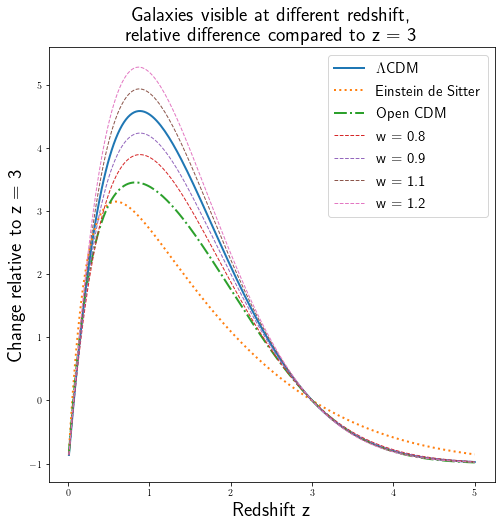

In [158]:
Zs = np.linspace(0.01, 5, num = 200)

plt.rcParams.update({"text.usetex": True})

def PlotDensityRelZ(Cosmology, Ws, z, Cosmoname, time, linestyle = "solid" , linewidth = 1):
    DMsz = DistModVec(time, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
    atZ = integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - DMsz))[0]
    Cosmo = np.array([integrate.quad(lambda x: SchechterMagnitudesdMag(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], x, 5), -35, (25 - i))[0] for i in DMsCos])
    
    atZ = np.prod([atZ, ComVolElVec(time, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
    RelDiff = np.subtract(Cosmo, atZ)
    RelDiff = np.divide(RelDiff, atZ)
    
    plt.plot(z, (RelDiff), label = Cosmoname, linestyle = linestyle, linewidth = linewidth)
    #plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title, fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    #plt.grid()
    plt.legend(fontsize = 15)
    
    plt.show()
    
   
plt.figure(figsize=(8,8))

PlotDensityRelZ(LCDM, wBasic, Zs, "$\Lambda$CDM", 3, linewidth = 2)
PlotDensityRelZ(EDS, wBasic, Zs, "Einstein de Sitter", 3, linewidth = 2, linestyle =":")
PlotDensityRelZ(OCDM, wBasic, Zs, "Open CDM", 3, linewidth = 2, linestyle ="-.")

PlotDensityRelZ(LCDM, w8, Zs, "w = 0.8", 3, linestyle = "--")
PlotDensityRelZ(LCDM, w9, Zs, "w = 0.9", 3, linestyle = "--")
PlotDensityRelZ(LCDM, w11, Zs, "w = 1.1", 3, linestyle = "--")
PlotDensityRelZ(LCDM, w12, Zs, "w = 1.2", 3, linestyle = "--")


Roundoff("Galaxies visible at different redshift, \n relative difference compared to z = 3", "Redshift z", "Change relative to z = 3 ")



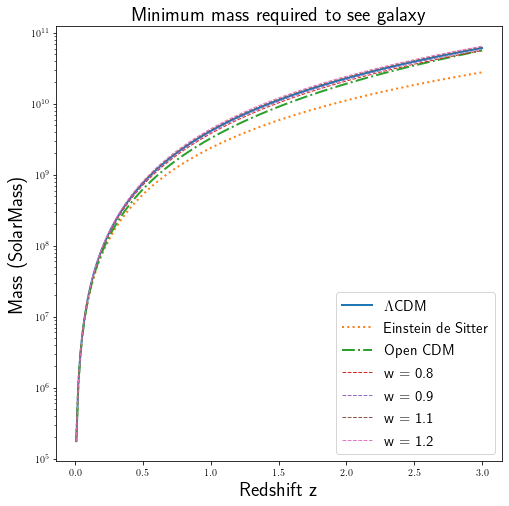

In [167]:
# Check the behaviour of visible masses as a function of redshift as in Mortlock paper.

Zs = np.linspace(0.01, 3, num = 200)

def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname, linestyle = "solid" , linewidth = 1):
    
    DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])

    Mags = 25 - DMsCos
    
    Luminosities = LumFromMagnitude(Mags)
    Masses = MassFromLum(Luminosities, 5)

    plt.plot(z, Masses, label = Cosmoname, linestyle = linestyle, linewidth = linewidth)
    plt.yscale("Log")
    
def Roundoff(title, xlabel, ylabel):
    plt.title(title, fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.ylabel(ylabel, fontsize = 20)
    #plt.grid()
    plt.legend(fontsize = 15)
    
    plt.show()
    
   
plt.figure(figsize=(8,8))
plt.yscale("Log")

PlotVisibleDensity(LCDM, wBasic, Zs, "$\Lambda$CDM", linewidth = 2)
PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter", linewidth = 2, linestyle =":")
PlotVisibleDensity(OCDM, wBasic, Zs, "Open CDM", linewidth = 2, linestyle ="-.")

PlotVisibleDensity(LCDM, w8, Zs, "w = 0.8", linestyle = "--")
PlotVisibleDensity(LCDM, w9, Zs, "w = 0.9", linestyle = "--")
PlotVisibleDensity(LCDM, w11, Zs, "w = 1.1", linestyle = "--")
PlotVisibleDensity(LCDM, w12, Zs, "w = 1.2", linestyle = "--")


Roundoff("Minimum mass required to see galaxy", "Redshift z", "Mass (SolarMass)")

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Ignore this point on !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Now I wanted to check what was going on each step of the way, so I test the behaviour of a set of magnitudes as they go through each function.

In [160]:

# AbsoluteMagnitudes = AbsMagFromMag(MagArray, 0, 0)

# plt.plot(MagArray, AbsoluteMagnitudes)
# plt.show()

In [161]:
# Luminosities = LumFromMagnitude(AbsoluteMagnitudes)

# plt.plot(MagArray, Luminosities)
# plt.yscale("Log")
# plt.show()

In [162]:
# Masses = MassFromLum(Luminosities)
# plt.plot(MagArray, Masses)
# plt.yscale("Log")
# plt.show()

In [163]:
# Schechter distribution of magnitudes

# Not showing expected behaviour!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Density = DoubleSchechterDiffVec(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], \
#                                  CanonicalSchechter[3], CanonicalSchechter[4], MassFromLum(LumFromMagnitude(
#     AbsMagFromMag(MagArray, DistanceModulus(0.5, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]), 0))))

# plt.plot(MagArray, Density)
# plt.yscale("Log")
# plt.show()

# Should be curve

From here I'm trying to integrate the double schecter function, but I haven't found a method that works. 

In [164]:
# def DensityAtZ(Phi1, Phi2, a1, a2, MassStar, z, OmeM, OmeCos, OmeK, w0, w1):
#     integral = integrate.quad(lambda M: DoubleSchechterDiffVec(Phi1, Phi2, a1, a2, MassStar, MassFromLum(LumFromMagnitude
#                         (AbsMagFromMag(M, DistanceModulus(z, OmeM, OmeCos, OmeK, w0, w1), 0)))), -np.inf, 25)
#     return integral[0]

In [165]:
# test = np.array([1,2,3])

# def func(a, b, c):
#     return c * a ** b
    

# UpTo25 = [(integrate.quad(lambda A: (func(A, 3, i)) , 0, 4)[0]) for i in test]

# print(UpTo25)

In [166]:

# def SchechterFromMag(mag, Phi1, Phi2, a1, a2, MassStar):
#     return np.exp(-(10**(-(mag)/2.5) * 3.0128*10**28)/MassStar) * (Phi1 * ((10**(-(mag)/2.5) * 3.0128*10**28)/MassStar)**a1 + Phi2 * ((10**(-(mag)/2.5) * 3.0128*10**28)/MassStar)**a2 )


# def DensityAtZ(Phi1, Phi2, a1, a2, MassStar, z, OmeM, OmeCos, OmeK, w0, w1):
#     Line_Of_Sight = ComDisLOSVec(z, OmeM, OmeCos, OmeK, w0, w1)
    
#     # 
#     if OmeCos == 0:
#         A = 2 - OmeM * (1-z)
#         B = (2 - OmeM) * np.sqrt(1 + OmeM * z)
#         C = OmeM**2 * (1 + z)
#         Transverse = 2 * (A - B)/C
        
#     else:
#         if OmeK > 0:
#             Transverse = (1 / np.sqrt(OmeK)) * np.sinh(np.sqrt(OmeK) * Line_Of_Sight )
#         elif OmeK < 0:
#             Transverse = (1 / np.sqrt(np.absolute(OmeK))) * np.sin(np.sqrt(np.absolute(OmeK)) * Line_Of_Sight )
#         elif OmeK == 0:
#             Transverse = Line_Of_Sight
    
#     LuminosityDist = (1 + z) * Transverse
    
#     DistModulus = 5 * np.log10(LuminosityDist)
    
#     KCorrection = 0
    
#     # Matrix of all possible magnitude input and all possible distance-modulus input?
#     # But this needs to be a function that can be integrated up to the desired apparent magnitude.
    
#     #UpTo25 = np.ones(len(DistanceModulus))
    
#     print(DistModulus)
    
#     UpTo25 = [(integrate.quad(lambda M: (SchechterFromAbsMag(M, CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4])) , -35, (25-i))[0]) for i in DistanceModulus]
    
#     print(UpTo25)
    
#     return UpTo25
# #     AbsMagnitude = apparentmagnitude - DistModulus - KCorrection
    
# #     Luminosity = 10**(-AbsMagnitude/2.5) * 3.0128*10**28
    
# #     # Schechter Function
# #     Density = np.exp(-Mass/MassStar) * (Phi1 * (Mass/MassStar)**a1 + Phi2 * (Mass/MassStar)**a2 ) * (1/(MassStar * MSol))





    

In [236]:
# print(DensityAtZ(CanonicalSchechter[0], CanonicalSchechter[1], CanonicalSchechter[2], CanonicalSchechter[3], CanonicalSchechter[4], 
#  np.array([0.5, 2, 3, 4, 5]), LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1]))

# One value of density at a disance z = 0.5 gives a runtime error. Must resolve this as need to calculate full spectrum
# of different z values.

# Also; 1.9 * 10^30 seems unnecessarily big? But this may also be because of the units of different quantities going
# into functions; as the luminosity to mass function is very much just a dummy function at the moment, haven't
# concentrated too much on units, concentrated on behaviour instead.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Part 3: Going back to the single schechter function

In [237]:
# def SingleSchechter(Phi, alph, MStar, M):
#     a = (2/5)*(MStar - M)
#     return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

# Phi = 0.002
# alph = -1.2
# MStar = -21

# test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, 4.5)
# print(test)

# magnitudes = np.linspace(-35, 25, num= 200)
# distrib = SingleSchechter(Phi, alph, MStar, magnitudes)

# plt.plot(magnitudes, distrib)
# plt.show()

In [238]:
# def SingleSchechter(Phi, alph, MStar, M):
#     a = (2/5)*(MStar - M)
#     return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

# Phi = 0.002
# alph = -1.2
# MStar = -21

# test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, 25)
# print(test)

# magnitudes = np.linspace(-35, 25, num= 200)
# distrib = SingleSchechter(Phi, alph, MStar, magnitudes)

# plt.plot(magnitudes, distrib)
# plt.show()

In [239]:
# Zs = np.linspace(0.01, 5, num = 200)

# DMs = DistModVec(Zs, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])

# #print(DMs)
# # How far is aboslute magnitude supposed to be? seems like DM always makes things brighter,
# # no matter how far away they are
# #m = M + DM + K

# test = integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - DMs[0]))
# #print(test)

# test = [integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMs]
# #print(test)

# plt.plot(Zs, test)
# plt.yscale("Log")
# plt.show()

In [240]:
# Zs = np.linspace(0.01, 5, num = 200)

# def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
#     DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
#     DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
#     Lambda = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsL])
#     Cosmo = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
#     Diff = np.subtract(Cosmo, Lambda)
    
#     plt.plot(z, Diff, label = Cosmoname)
#     #plt.yscale("Log")
    
# def Roundoff(title, xlabel, ylabel):
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid()
#     plt.legend()
    
#     plt.show()
    
   
# plt.figure(figsize=(8,8))

# PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
# PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
# PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

# PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
# PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
# PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
# PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


# Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")

In [245]:
# Zs = np.linspace(0.01, 5, num = 200)

# def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
#     DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
#     DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
#     Lambda = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsL])
#     Cosmo = np.array([integrate.quad(lambda x: SingleSchechter(Phi, alph, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
#     Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
#     Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
#     Diff = np.subtract(Cosmo, Lambda)
    
#     plt.plot(z, Diff, label = Cosmoname)
#     #plt.yscale("Log")
    
# def Roundoff(title, xlabel, ylabel):
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid()
#     plt.legend()
    
#     plt.show()
    
   
# plt.figure(figsize=(8,8))

# PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
# PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
# PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

# PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
# PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
# PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
# PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


# Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")

Back to Double Schechter...

In [242]:
# def SingleSchechter(Phi, alph, MStar, M):
#     a = (2/5)*(MStar - M)
#     return (2/5) * Phi * np.log(10) * (10**(a * (alph + 1))) * np.exp(-10**a)

# def DoubleSchechterDiff(Phi1, Phi2, a1, a2, MassStar, Mass): #in MASSES =(
#     Density = np.exp(-Mass/(MassStar)) * (Phi1 * (Mass/(MassStar))**a1 + Phi2 * (Mass/(MassStar))**a2 ) * (1/(MassStar))
#     #Density = np.exp(-Mass/(MassStar)) * (Phi1 * (Mass/(MassStar))**a1 + Phi2 * (Mass/(MassStar))**a2 ) * (Mass/(MassStar))
#     # For units as in the paper, we have d(mass)/ d(log(mass)) = mass
#     return Density

# DoubleSchechterVec = np.vectorize(DoubleSchechterDiff)

# Phi1 = 3.96*10**-3
# Phi2 = 0.79*10**-3
# a1 = -0.35
# a2 = -1.47
# MStar = 10**10.66


# test = integrate.quad(lambda x: DoubleSchechterDiff(Phi1, Phi2, a1, a2, MStar, x), -25, 25)
# print(test)

# magnitudes = np.linspace(-35, 25, num= 200)
# distrib = DoubleSchechterVec(Phi1, Phi2, a1, a2, MStar, magnitudes)

# plt.plot(magnitudes, distrib)
# plt.show()

In [243]:
# Zs = np.linspace(0.01, 5, num = 200)

# DMs = DistModVec(Zs, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])

# #print(DMs)
# # How far is aboslute magnitude supposed to be? seems like DM always makes things brighter,
# # no matter how far away they are
# #m = M + DM + K

# test = integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - DMs[0]))
# #print(test)

# test = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMs])
# #print(test)
# #Far too big!!! Numbers are huge.

# plt.plot(Zs, test)
# plt.yscale("Log")
# plt.show()

In [244]:
# Zs = np.linspace(0.01, 5, num = 200)

# def PlotVisibleDensity(Cosmology, Ws, z, Cosmoname):
#     DMsL = DistModVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])
#     DMsCos = DistModVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])
    
#     Lambda = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMsL])
#     Cosmo = np.array([integrate.quad(lambda x: DoubleSchechter(Phi1, Phi2, a1, a2, MStar, x), -35, (25 - i))[0] for i in DMsCos])
    
#     Lambda = np.prod([Lambda, ComVolElVec(z, LCDM[0], LCDM[1], LCDM[2], wBasic[0], wBasic[1])], axis = 0)
#     Cosmo = np.prod([Cosmo, ComVolElVec(z, Cosmology[0], Cosmology[1], Cosmology[2], Ws[0], Ws[1])], axis = 0)
    
#     Diff = np.subtract(Cosmo, Lambda)
    
#     plt.plot(z, Diff, label = Cosmoname)
#     #plt.yscale("Log")
    
# def Roundoff(title, xlabel, ylabel):
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.grid()
#     plt.legend()
    
#     plt.show()
    
   
# plt.figure(figsize=(8,8))

# PlotVisibleDensity(LCDM, wBasic, Zs, "LCDM")
# PlotVisibleDensity(EDS, wBasic, Zs, "Einstein de Sitter")
# PlotVisibleDensity(OCDM, wBasic, Zs, "Open")

# PlotVisibleDensity(LCDM, w8, Zs, "w1 = 0.8")
# PlotVisibleDensity(LCDM, w9, Zs, "w1 = 0.9")
# PlotVisibleDensity(LCDM, w11, Zs, "w1 = 1.1")
# PlotVisibleDensity(LCDM, w12, Zs, "w1 = 1.2")


# Roundoff("Density of visible galaxies at different redshift", "Redshift z", "Density relative to lambda CDM")